#Import

In [ ]:
#import des librairies
import pandas as pd
import seaborn as sns
import numpy as np
import time
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt # plotting
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from math import sqrt
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Création du jeu de données

In [67]:
#étape de prédiction (t+(7x30minutes))
t_step = 7

nb_lignes = 20000
nb_donnees_test = 200

#modification dimensions graphiques
sns.set(rc = {'figure.figsize':(15,8)})
WAVE_PATH = "/content/wave.csv"
#import csv
datas = pd.read_csv(WAVE_PATH,parse_dates=True,index_col=0,nrows=nb_lignes) 
#on remplace les valeurs absurdes par des valeurs nulles
datas.replace(-99.90, np.nan, inplace=True)
#interpolation des données manquantes
datas = datas.interpolate(limit_direction='both')
datas.index = pd.to_datetime(datas.index).to_period('15T')
#renommage des colonnes
datas = datas.rename(columns={'Peak Direction': 'Peak_Direction'})
datas = datas.rename(columns={'SST': 'Temperature'})
datas = datas.rename(columns={'Tz': 'Period'})

#Analyse des données

In [ ]:
datas.describe()

,Hs,Hmax,Period,Tp,Peak_Direction,Temperature
count,43728.000000,43728.000000,43728.000000,43728.000000,43728.000000,43728.000000
mean,1.238436,2.091178,5.617490,9.005985,98.598678,23.957782
std,0.529151,0.898393,0.928551,2.391658,24.273768,2.232209
min,0.294000,0.510000,3.076000,2.720000,5.000000,19.800000
25%,0.840000,1.410000,4.977000,7.289000,85.000000,21.900000
50%,1.130000,1.910000,5.527000,8.884000,101.000000,23.950000
75%,1.544000,2.600000,6.164000,10.672000,116.000000,26.050000
max,4.257000,7.906000,10.921000,21.121000,358.000000,28.650000


In [ ]:
print(datas.head())
print(datas.shape)
print(datas.columns)


                     Hs  Hmax  Period     Tp  Peak_Direction  Temperature
Date/Time                                                                
2017-01-01 00:00  0.875  1.39   4.421  4.506            49.0        25.65
2017-01-01 00:30  0.875  1.39   4.421  4.506            49.0        25.65
2017-01-01 01:00  0.763  1.15   4.520  5.513            49.0        25.65
2017-01-01 01:30  0.770  1.41   4.582  5.647            75.0        25.50
2017-01-01 02:00  0.747  1.16   4.515  5.083            91.0        25.45
(43728, 6)
Index(['Hs', 'Hmax', 'Period', 'Tp', 'Peak_Direction', 'Temperature'], dtype='object')


In [ ]:
datas

,Hs,Hmax,Period,Tp,Peak_Direction,Temperature
Date/Time,,,,,,
2017-01-01 00:00,0.875,1.39,4.421,4.506,49.0,25.65
2017-01-01 00:30,0.875,1.39,4.421,4.506,49.0,25.65
2017-01-01 01:00,0.763,1.15,4.520,5.513,49.0,25.65
2017-01-01 01:30,0.770,1.41,4.582,5.647,75.0,25.50
2017-01-01 02:00,0.747,1.16,4.515,5.083,91.0,25.45
...,...,...,...,...,...,...
2019-06-30 21:30,2.299,3.60,9.281,12.765,94.0,21.95
2019-06-30 22:00,2.075,3.04,9.303,12.722,95.0,21.95
2019-06-30 22:30,2.157,3.43,9.168,12.890,97.0,21.95


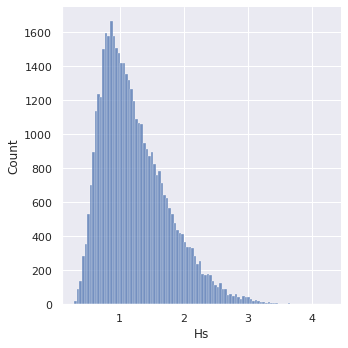

In [ ]:
sns.displot(datas["Hs"])

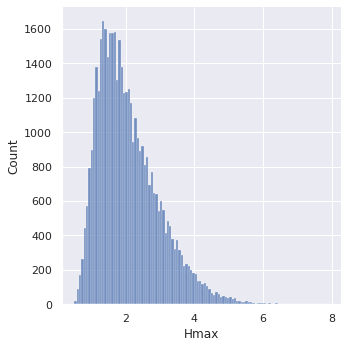

In [ ]:
sns.displot(datas["Hmax"])

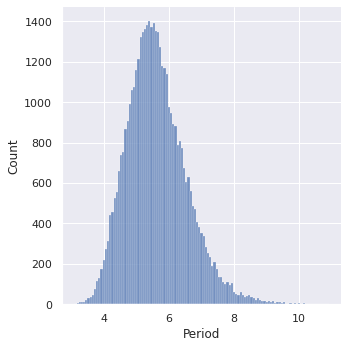

In [ ]:
sns.displot(datas["Period"])

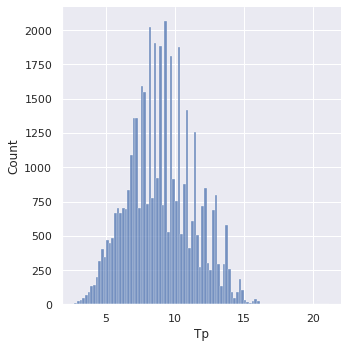

In [ ]:
sns.displot(datas["Tp"])

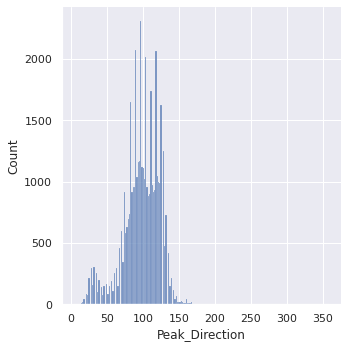

In [ ]:
sns.displot(datas["Peak_Direction"])

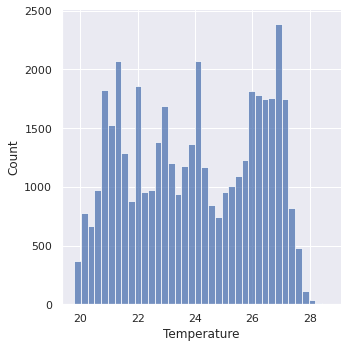

In [ ]:
sns.displot(datas["Temperature"])

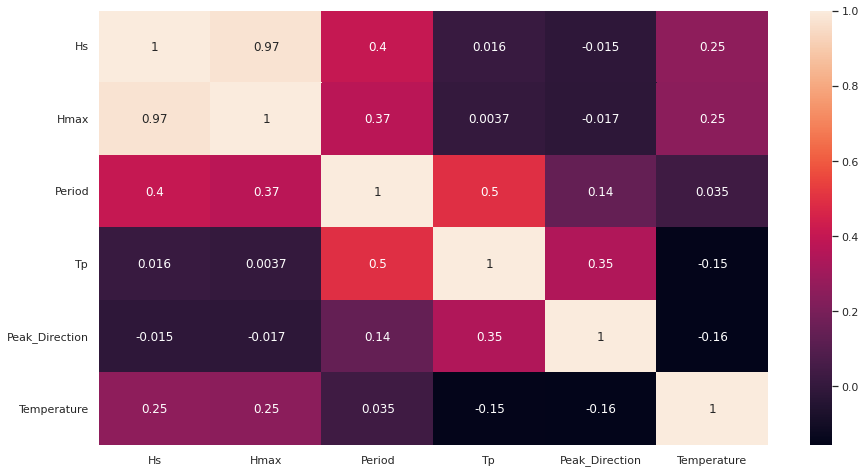

In [ ]:
sns.heatmap(datas.corr(),annot=True)

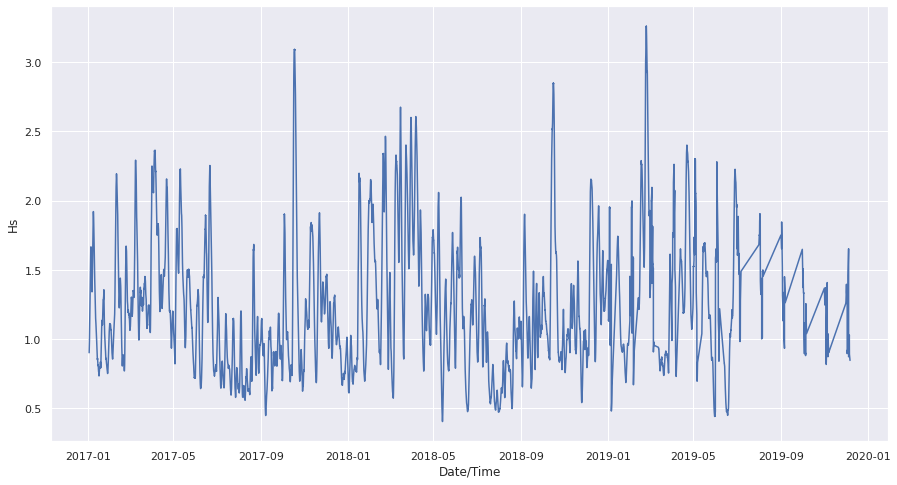

In [ ]:
#remove noise
rolling =  datas.rolling(window=100).mean()
rolling.dropna(inplace=True)
sns.lineplot(data=rolling,x=rolling.index.to_timestamp(),y="Hs")

#Apprentissage par machine

## Paramètres ARIMA

In [48]:
train=datas.iloc[:-nb_donnees_test,0]
test=datas.iloc[-nb_donnees_test:,0]
print(train.shape,test.shape)

(14900,) (100,)


In [49]:
#Is it stationnary ? 
result=adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
result_diff = adfuller(train.diff().dropna())
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
#if p-value <= 0.05 : NO 

ADF Statistic: -6.290841
p-value: 0.000000
ADF Statistic: -25.853469
p-value: 0.000000


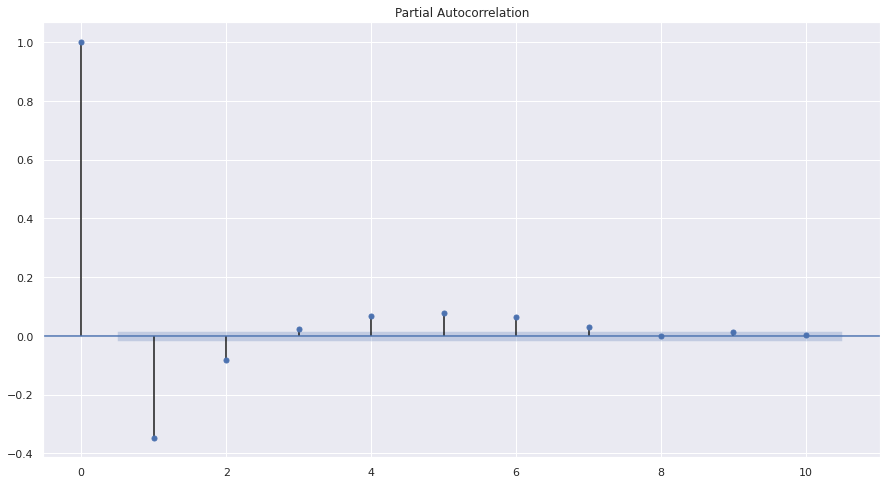

In [50]:
#p ?
x=plot_pacf((train.diff()).dropna(),lags=10)

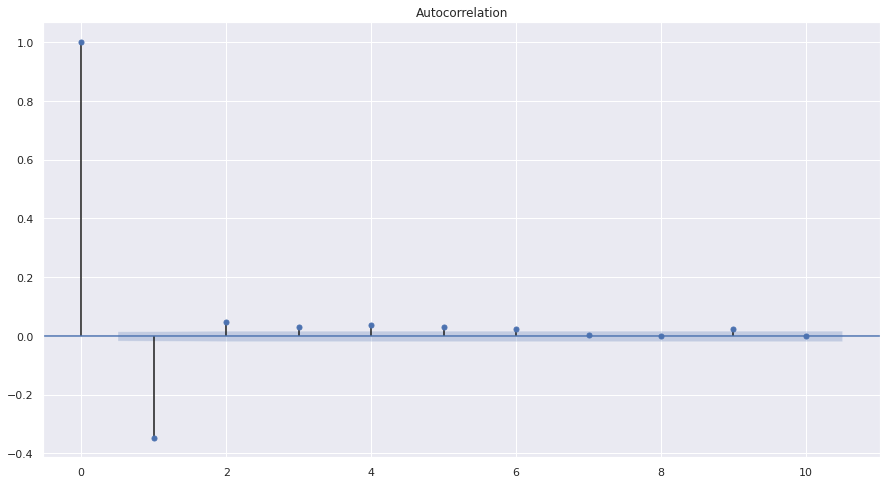

In [51]:
#q ?
x=plot_acf((train.diff()).dropna(),lags=10)

## Résumé du modèle

In [ ]:
model = ARIMA(train, order=(1,0,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                     Hs   No. Observations:                43628
Model:                     ARMA(1, 1)   Log Likelihood               52244.543
Method:                       css-mle   S.D. of innovations              0.073
Date:                Wed, 09 Feb 2022   AIC                        -104481.085
Time:                        20:19:19   BIC                        -104446.352
Sample:                    01-01-2017   HQIC                       -104470.136
                         - 06-28-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2389      0.056     22.057      0.000       1.129       1.349
ar.L1.Hs       0.9960      0.000   2321.918      0.000       0.995       0.997
ma.L1.Hs      -0.3566      0.004    -88.462      0.0

## Modèle 1-step

### Entraînement du modèle 1-step

In [52]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,0,1))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))


predicted=0.909587, expected=0.868000
predicted=0.883216, expected=0.921000
predicted=0.909591, expected=0.964000
predicted=0.946871, expected=0.887000
predicted=0.908208, expected=0.913000
predicted=0.912594, expected=0.874000
predicted=0.888195, expected=0.899000
predicted=0.896659, expected=0.911000
predicted=0.907428, expected=1.002000
predicted=0.971345, expected=1.075000
predicted=1.041006, expected=1.236000
predicted=1.170972, expected=1.305000
predicted=1.259953, expected=1.417000
predicted=1.363849, expected=1.517000
predicted=1.464733, expected=1.628000
predicted=1.571932, expected=1.722000
predicted=1.669921, expected=1.807000
predicted=1.758865, expected=1.952000
predicted=1.884778, expected=1.950000
predicted=1.924984, expected=2.130000
predicted=2.058154, expected=1.905000
predicted=1.952157, expected=1.974000
predicted=1.963169, expected=2.232000
predicted=2.138579, expected=2.265000
predicted=2.218482, expected=2.219000
predicted=2.214149, expected=2.032000
predicted=2.

### Evaluation du modèle 1-step

Test RMSE: 0.105


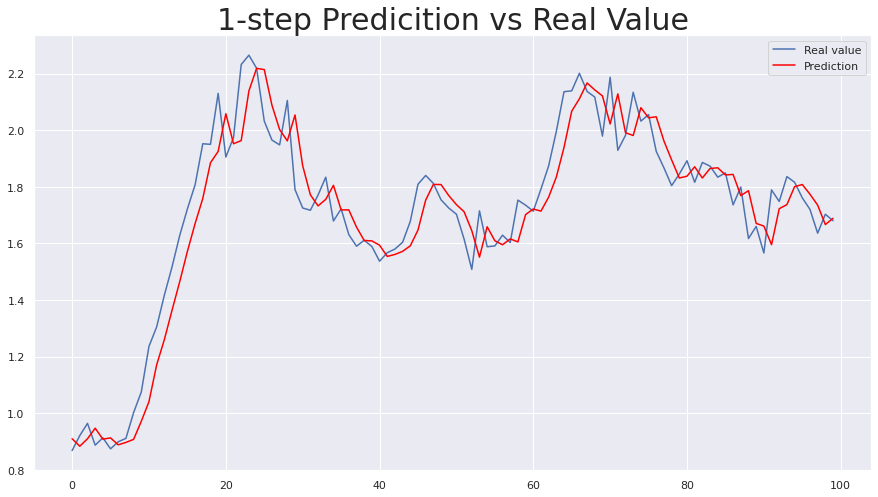

In [61]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test.values,label="Real value")
plt.plot(predictions,color='red',label="Prediction")
plt.legend(loc="upper right")
plt.title("1-step Predicition vs Real Value",
          fontsize=30)
plt.show()


## Modèle k-step

### Entraînement du modèle k-step

In [62]:
history2 = [x for x in train]
predictions2 = list()
comparaison  = list()
# walk-forward validation
for t in range(len(test)-(t_step-1)):
	model = ARIMA(history2, order=(1,0,1))
	model_fit = model.fit()
	output = model_fit.forecast(steps=t_step)
	yhat = output[0][-1]
	predictions2.append(yhat)
	obs = test[t+(t_step-1)]
	comparaison.append(obs)
	history2.append(test[t])
	print('predicted=%f, expected=%f' % (yhat, obs))
  

predicted=0.916724, expected=0.899000
predicted=0.891061, expected=0.911000
predicted=0.916727, expected=1.002000
predicted=0.953002, expected=1.075000
predicted=0.915380, expected=1.236000
predicted=0.919647, expected=1.305000
predicted=0.895903, expected=1.417000
predicted=0.904139, expected=1.517000
predicted=0.914618, expected=1.628000
predicted=0.976813, expected=1.722000
predicted=1.044593, expected=1.807000
predicted=1.171040, expected=1.952000
predicted=1.257605, expected=1.950000
predicted=1.358677, expected=2.130000
predicted=1.456822, expected=1.905000
predicted=1.561119, expected=1.974000
predicted=1.656466, expected=2.232000
predicted=1.743028, expected=2.265000
predicted=1.865598, expected=2.219000
predicted=1.904747, expected=2.032000
predicted=2.034453, expected=1.965000
predicted=1.931211, expected=1.948000
predicted=1.941943, expected=2.105000
predicted=2.112850, expected=1.790000
predicted=2.190731, expected=1.725000
predicted=2.186516, expected=1.717000
predicted=2.

### Evaluation du modèle k-step

Test RMSE: 0.305


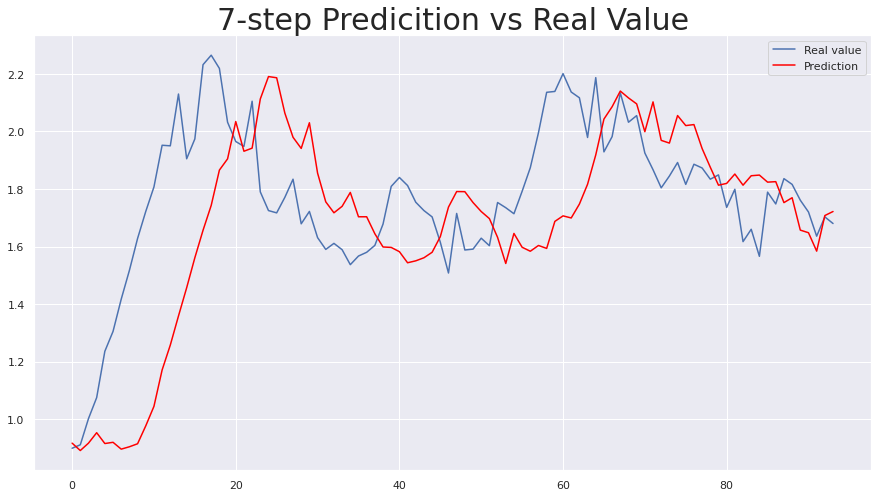

In [69]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(predictions2,comparaison))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(comparaison,label="Real value")
plt.plot(predictions2,color='red',label="Prediction")
plt.legend(loc="upper right")
plt.title(str(t_step)+"-step Predicition vs Real Value",
          fontsize=30)
plt.show()